# Import packages

In [21]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Load data

In [34]:
file_path = '../processed_data/cleaned_data_final.csv'



df = pd.read_csv(file_path)

df.head()


,name,male,origin,isMarried,isNoble,popularity,isAlive,season,episode,deaths,episode_num
0,Viserys II Targaryen,1,House Targaryen,0,0,0.605351,0,8,The Bells,Lord Varys - Burned alive by Drogon with his f...,71
1,Walder Frey,1,House Frey,1,1,0.896321,0,6,The Winds of Winter,Lord Walder Frey - Throat slit by Arya Stark w...,60
2,Addison Hill,1,House Lannister,0,1,0.267559,1,0,NaN,NaN,0
3,Aemma Arryn,0,House Arryn,1,1,0.183946,0,5,The Gift,Maester Aemon Targaryen - Died of natural causes.,47
4,Sylva Santagar,0,House Martell,1,1,0.043478,1,0,NaN,NaN,0


In [35]:
df.drop(labels=['episode','deaths','name'],axis=1, inplace=True)


In [36]:
df.columns


Index(['male', 'origin', 'isMarried', 'isNoble', 'popularity', 'isAlive',
       'season', 'episode_num'],
      dtype='object')

# Encoding of features

In [25]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   male         1949 non-null   int64  
 1   origin       1949 non-null   object 
 2   isMarried    1949 non-null   int64  
 3   isNoble      1949 non-null   int64  
 4   popularity   1949 non-null   float64
 5   isAlive      1949 non-null   int64  
 6   season       1949 non-null   int64  
 7   episode_num  1949 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 121.9+ KB


<Axes: >

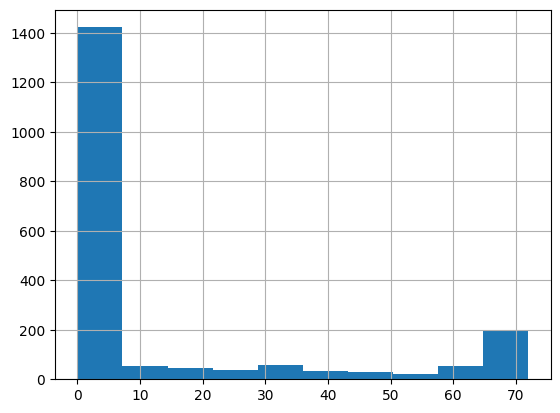

In [26]:
df.episode_num.hist()


<Axes: >

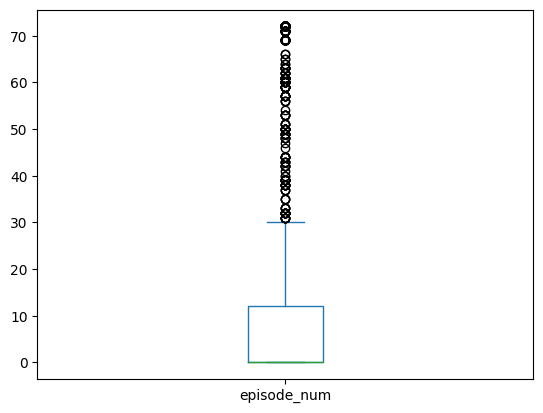

In [29]:
df.episode_num.plot(kind='box')


<Axes: >

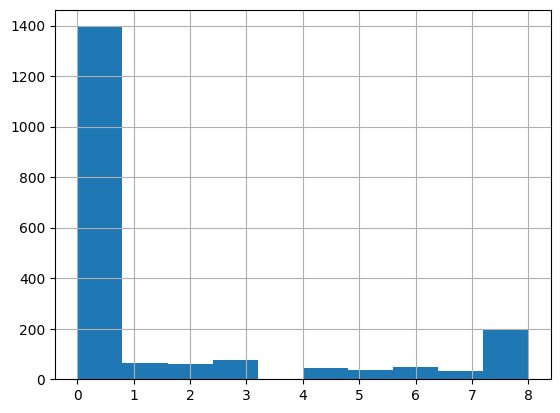

In [31]:
df.season.hist()


<Axes: >

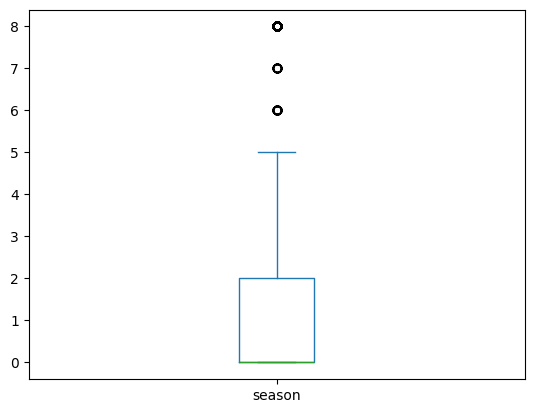

In [30]:
df.season.plot(kind='box')


In [33]:
df.season.value_counts(dropna=False, normalize=True)


season
0    0.714726
8    0.100051
3    0.038994
1    0.032324
2    0.031298
6    0.024115
4    0.023089
5    0.019497
7    0.015906
Name: proportion, dtype: float64

# Apply K-means